In [ ]:
!pip install monai # 3d tool
!pip install natsort

  Obtaining dependency information for monai from https://files.pythonhosted.org/packages/08/94/e8a7ba00dd0c7ce959648b562043bd22125d65f5e519e566c822f71bc437/monai-1.3.0-202310121228-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for natsort from https://files.pythonhosted.org/packages/ef/82/7a9d0550484a62c6da82858ee9419f3dd1ccc9aa1c26a1e43da3ecd20b0d/natsort-8.4.0-py3-none-any.whl.metadata


In [ ]:
import os
import random
import shutil
import tempfile
import time
import numpy as np
import matplotlib.pyplot as plt

from monai.data import DataLoader, decollate_batch, Dataset
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet, SegResNet
from monai.transforms import (
    Activations,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    AsDiscrete,

)

import torch
from pathlib import Path
from natsort import natsorted
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
class cfg:
    base_path = Path('/kaggle/input/brats20-dataset-training-validation/')
    train_path = base_path/'BraTS2020_TrainingData'/'MICCAI_BraTS2020_TrainingData'
    test_path = base_path/'BraTS2020_ValidationData'/'MICCAI_BraTS2020_ValidationData'
    seed = 2023
    max_epochs = 20
    val_interval =1
    in_channels=4
    out_channels=3


## Make dataset
* 학습 or inference를 하기 위해서 dataset을 구성하여줍니다.
* 추후에 augmentation을 적용하기 위해서는 dictionary형태가 필요함으로 dictionary 형태로 만들어줍니다.


In [ ]:
## load all dataset folder
train_folder_pathes = natsorted(list(cfg.train_path.glob('*')))

train_data_dicts = []
for sample_path in tqdm(train_folder_pathes):
    ## get images and labels
    if len(list(sample_path.glob('*.nii'))) == 5:
        flairs_path = sample_path/str(sample_path.name+'_flair.nii')
        t1_path     = sample_path/str(sample_path.name+'_t1.nii')
        t1ce_path   = sample_path/str(sample_path.name+'_t1ce.nii')
        t2_path     = sample_path/str(sample_path.name+'_t2.nii')
        mask_path   = sample_path/str(sample_path.name+'_seg.nii')

        if all([i.is_file() for i in [flairs_path, t1_path, t1ce_path, t2_path, mask_path]]):
            train_data_dicts.append({
                'image':[flairs_path,t1_path,t1ce_path,t2_path],
                'label':[mask_path]}
                )
        else:
            print(f'problem folder name:{sample_path}')
    else:
        print(sample_path)



  0%|          | 0/371 [00:00<?, ?it/s]

problem folder name:/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355
/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv


In [ ]:
## load all dataset folder
test_folder_pathes = natsorted(list(cfg.test_path.glob('*')))

test_data_dicts = []
for sample_path in tqdm(test_folder_pathes):
    ## get images and labels
    if len(list(sample_path.glob('*.nii'))) == 4:
        flairs_path = sample_path/str(sample_path.name+'_flair.nii')
        t1_path     = sample_path/str(sample_path.name+'_t1.nii')
        t1ce_path   = sample_path/str(sample_path.name+'_t1ce.nii')
        t2_path     = sample_path/str(sample_path.name+'_t2.nii')

        if all([i.is_file() for i in [flairs_path, t1_path, t1ce_path, t2_path]]):
            test_data_dicts.append({
                'image':[flairs_path,t1_path,t1ce_path,t2_path]
                })
        else:
            print(f'problem folder name:{sample_path}')
    else:
        print(sample_path)



  0%|          | 0/127 [00:00<?, ?it/s]

/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv


In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    label 1 + 2 -> TC
    label 1 + 2 +3 -> WT
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

* 20% 해당되어지는 부분만 Train/valid로 분할

In [ ]:
from sklearn.model_selection import train_test_split
train_dict, valid_dict = train_test_split(train_data_dicts, test_size=0.2, random_state=2023)

In [ ]:
train_dataset = Dataset(train_dict, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

valid_dataset = Dataset(valid_dict, transform=val_transform)
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

image shape: torch.Size([4, 240, 240, 155])


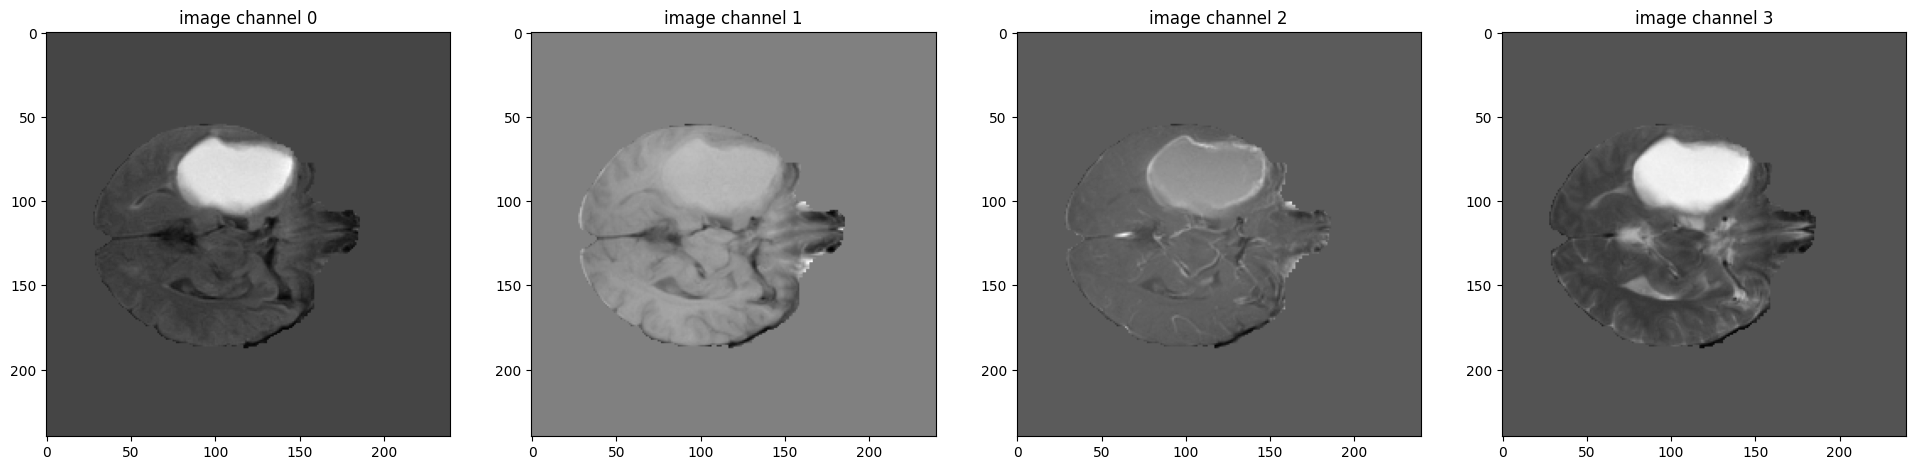

label shape: torch.Size([3, 240, 240, 155])


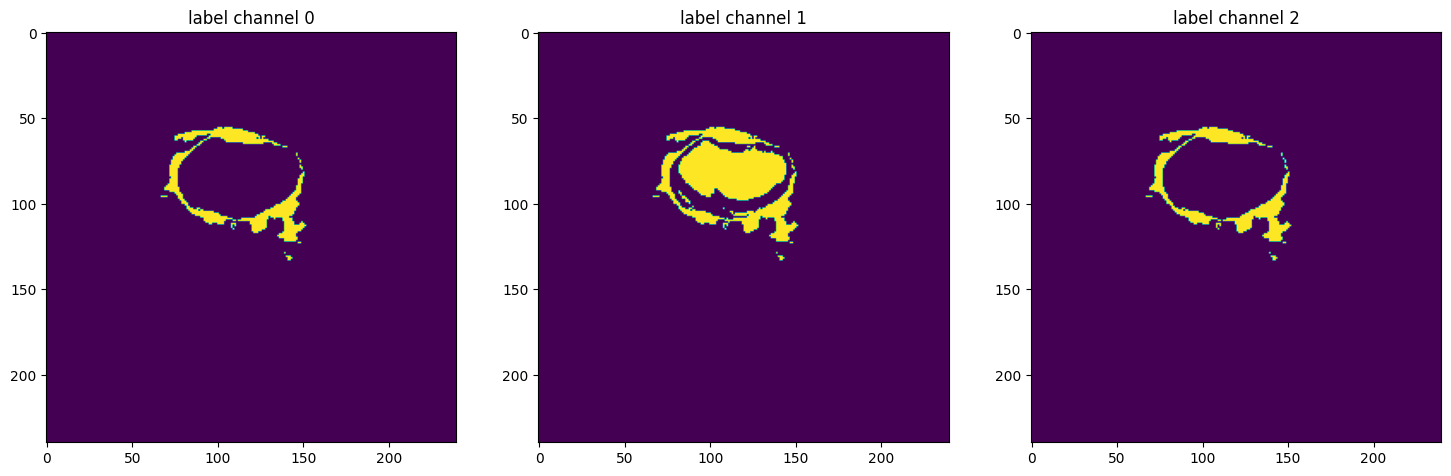

In [ ]:
val_data_example = valid_dataset[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(cfg.seed)

In [ ]:
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).cuda()
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])



# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(cfg.max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{cfg.max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = batch_data["image"].to('cuda'), batch_data["label"].to('cuda')
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
#         loss.backward()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        if step %30 == 0 :
            print(
                f"{step}/{len(train_dataset) // train_loader.batch_size}"
                f", train_loss: {loss.item():.4f}"
                f", step time: {(time.time() - step_start):.4f}"
            )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % cfg.val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to('cuda'),
                    val_data["label"].to('cuda')
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join('./', "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/20
30/294, train_loss: 0.8879, step time: 2.9761
60/294, train_loss: 0.8569, step time: 2.9737
90/294, train_loss: 0.8130, step time: 2.9702
120/294, train_loss: 0.9486, step time: 2.9557
150/294, train_loss: 0.9676, step time: 2.9425
180/294, train_loss: 0.8577, step time: 2.9572
210/294, train_loss: 0.8652, step time: 2.9639
240/294, train_loss: 0.8122, step time: 2.9689
270/294, train_loss: 0.8294, step time: 2.9658
epoch 1 average loss: 0.8947
saved new best metric model
current epoch: 1 current mean dice: 0.4948 tc: 0.4336 wt: 0.6145 et: 0.4244
best mean dice: 0.4948 at epoch: 1
time consuming of epoch 1 is: 1014.0126
----------
epoch 2/20
30/294, train_loss: 0.9242, step time: 2.9633
60/294, train_loss: 0.8365, step time: 2.9766
90/294, train_loss: 0.7070, step time: 2.9662
120/294, train_loss: 0.6606, step time: 2.9809
150/294, train_loss: 0.8517, step time: 2.9527
180/294, train_loss: 0.8893, step time: 2.9677
210/294, train_loss: 0.7817, step time: 2.9758
24

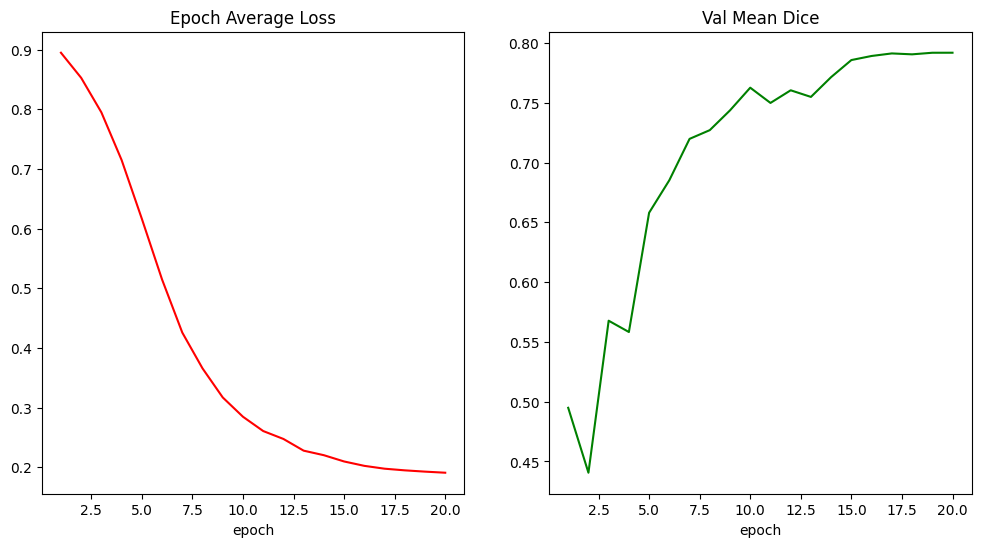

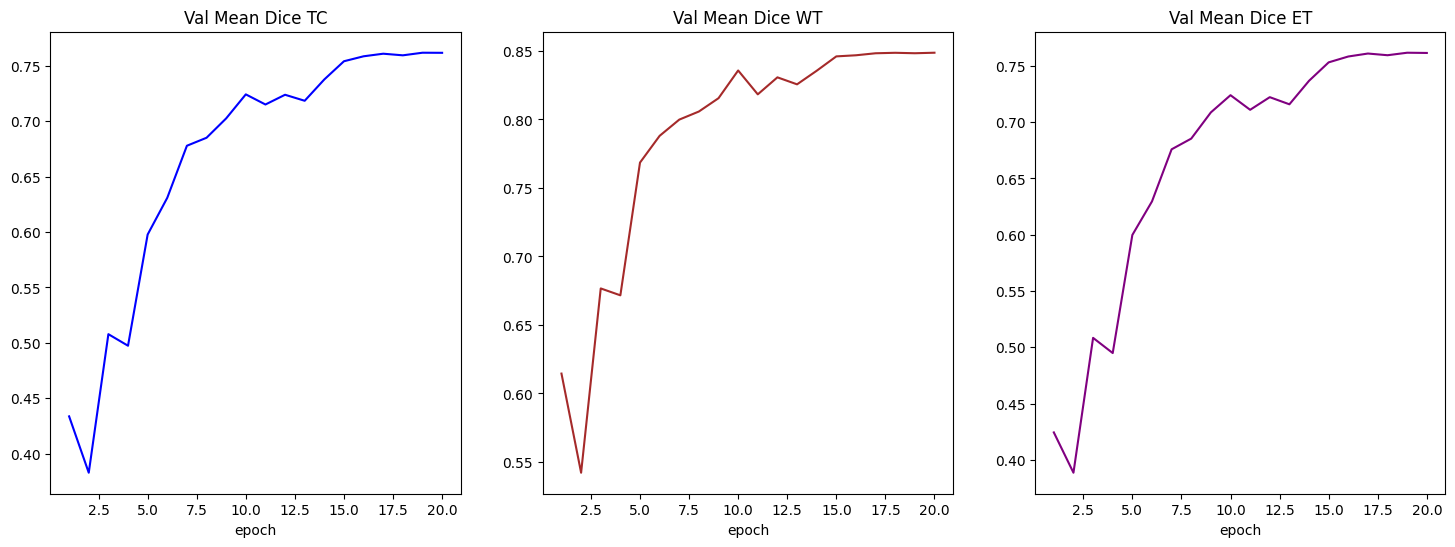

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

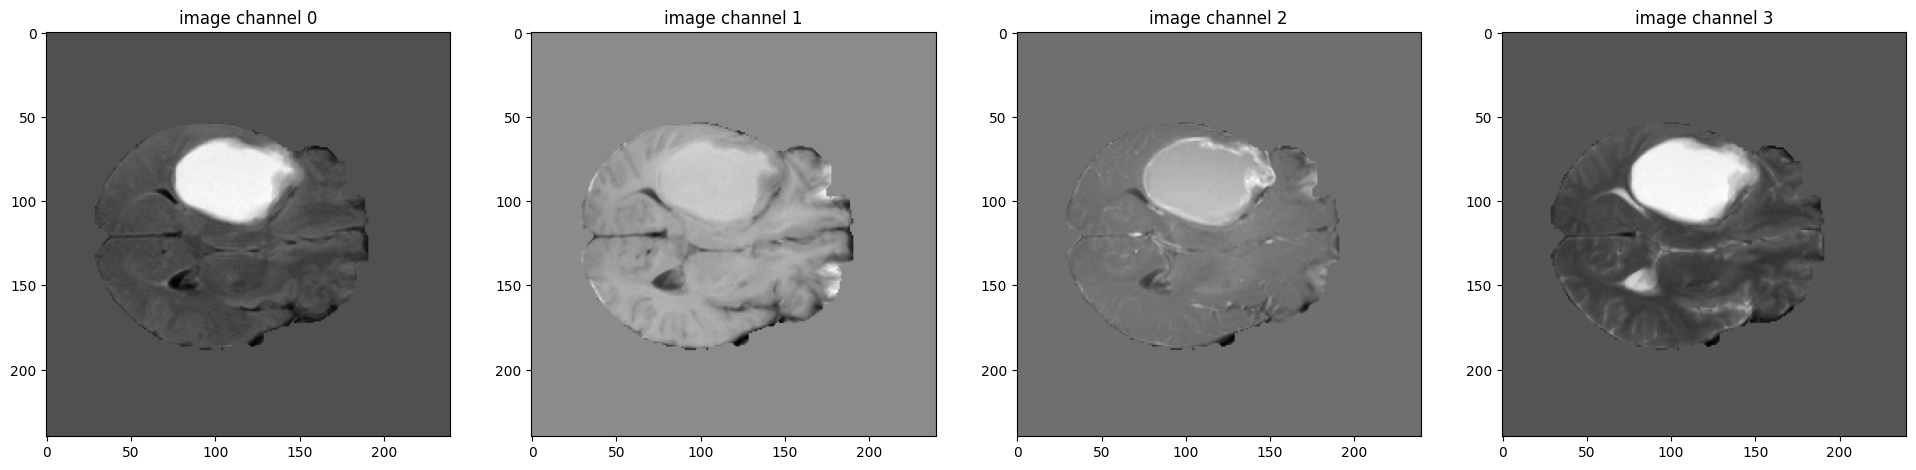

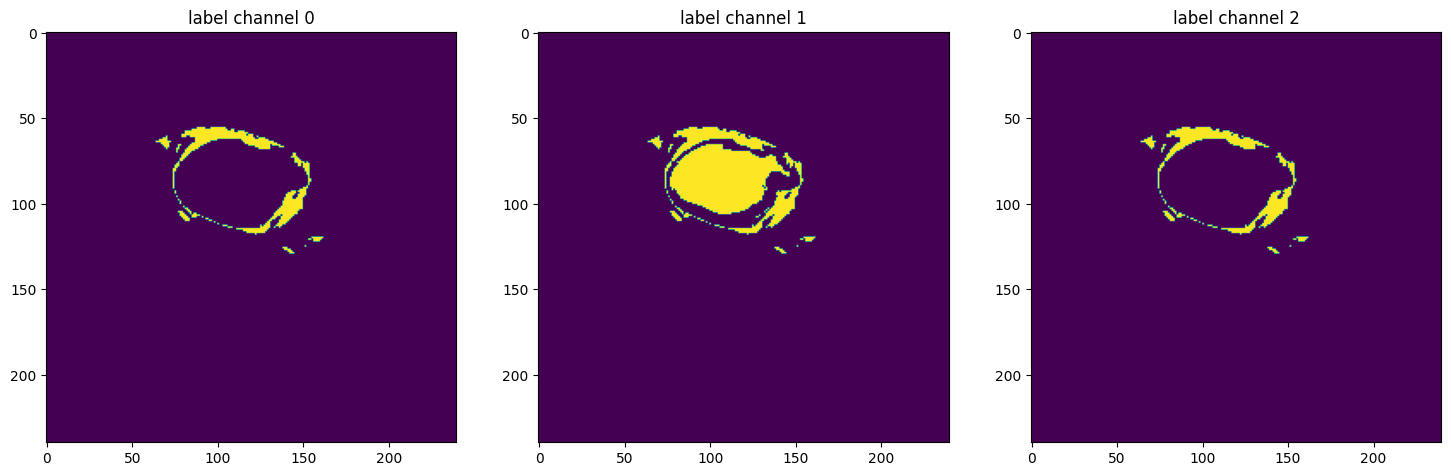

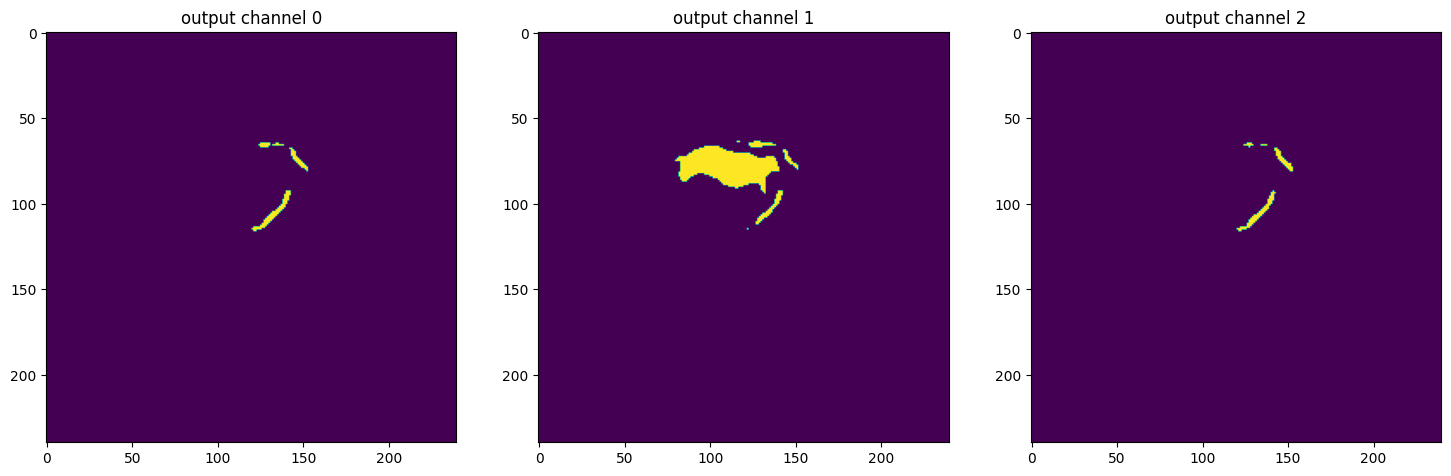

In [ ]:
model.load_state_dict(torch.load(os.path.join('./', "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = valid_dataset[2]["image"].unsqueeze(0).cuda()
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(valid_dataset[2]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(valid_dataset[2]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()